In [7]:
import scvelo as scv
import scanpy as sc
import glob
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import pandas as pd

def scv_velocity_on_embedding(f_embedding, LOOM, f_cell_cycle, fout_figure, markers=None):
    """\
    velocity plot on top of a given embedding (as csv file)
    Arguments
    ---------
    f_embedding:
        csv file with embedding (two columns represent coordinates). Row names should match cell names in loom
    LOOM:
        filename of a loom file OR AnnData object OR list of AnnData objects
    f_cell_cycle:
        file with a list of cell cycle genes to be gemoved from the analysis. Can be None.
    fout_figure:
        Output file to save the figure
    markers: (default: `None`)
        list of genes to include in velocity analysis. By default, all genes are considered.
    Returns
    -------
        `AnnData` object
    """
    print('Params:')
    print([f_embedding, LOOM, f_cell_cycle, fout_figure])
    print('Loading loom...')
    #path = Path(PATH)
    #print(path.parent+'loom')
    if isinstance(LOOM, sc.AnnData):
        adata_raw = LOOM
    elif isinstance(LOOM, list):
        l_adata = [scv.read(f_loom, sparse=True, cache=True) for f_loom in LOOM]
        adata_raw = l_adata[0]
        adata_raw = adata_raw.concatenate(l_adata[1:])

    else:
        f_loom = LOOM #glob.glob(PATH+'/../loom/'+'*.loom')[0]
        print(f_loom)
        adata_raw = scv.read(f_loom, sparse=True, cache=True)

    if f_cell_cycle is None:
        cell_cycle_genes = []
    else:
        print('Loading cell cycle genes...')
        #cell_cycle_genes = pd.read_csv(f_cell_cycle).gene.ravel()
        cell_cycle_genes = [x.upper() for x in pd.read_csv(f_cell_cycle).gene.ravel()]
        print(cell_cycle_genes[:10])

    print('Loading embedding...')
    emb_csv = scv.read(f_embedding) #'d2_ccrm.umap.csv'
    emb_csv.obs.index = [x.rstrip('-1') for x in emb_csv.obs.index]
    adata_raw.obs.index = [x.split('-')[0] for x in adata_raw.obs.index]

    print('Sample names in embedding:')
    print(emb_csv.obs.index[1:10])
    print('Sample names in loom:')
    print(adata_raw.obs.index[1:10])
    print('before filtering:')
    print(adata_raw.shape)
    
    shared_cells = list(set(emb_csv.obs.index).intersection( set(adata_raw.obs.index) ))
    print('Shared cells:')
    print(len(shared_cells))

    adata = adata_raw[shared_cells].copy()
    adata.obsm['X_umap'] = emb_csv[shared_cells].X.copy()
    print('after cell filtering:')
    print(adata.shape)

    adata = adata[:, [x not in cell_cycle_genes for x in adata.var.index]]
    print('after removal of cell cycle genes:')
    print(adata.shape)

    if markers is not None:
        adata = adata[:, [x in markers for x in adata.var.index]]
        print('after removal of cell cycle genes:')
        print(adata.shape)


    print('Velocity...')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=15, n_neighbors=30)

    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)

    print('Clustering...')
    scv.tl.louvain(adata)

    print('Plot...')
    print(fout_figure)
    scv.pl.velocity_embedding_stream(adata, legend_loc='on data', basis='umap', dpi=400)#, save=fout_figure+'.stream.png')
    plt.savefig(fout_figure+'.stream.png')

    scv.pl.velocity_embedding_grid(adata, legend_loc='on data', basis='umap', dpi=400)#, save=fout_figure)
    plt.savefig(fout_figure)
    
    return adata


# Load data

In [8]:
LOOM = [
 '../data/velocyto/10X_19_IA_02_R30/10X_19_001/velocyto/possorted_genome_bam_LW967.loom',
 '../data/velocyto/10X_19_IA_02_R39/10X_19_063/velocyto/possorted_genome_bam_DULJA.loom',
 '../data/velocyto/10X_19_IA_02_R43/10X_19_088/velocyto/possorted_genome_bam_S86AZ.loom',
 '../data/velocyto/10X_19_IA_02_R48/10X_19_123/velocyto/possorted_genome_bam_D53OX.loom',
 '../data/velocyto/10X_19_IA_02_R48/10X_19_124/velocyto/possorted_genome_bam_1D5GY.loom',
 '../data/velocyto/10X_19_IA_02_R48/10X_19_125/velocyto/possorted_genome_bam_PW1VR.loom']

LOOM_annot = ["R30_w8.5", "R39_w9.5", "R43_w6", "R48a_w14.5", "R48b_w12", "R48c_w8.5"]

In [9]:
import scvelo as scv

l_adata = [scv.read(f_loom, sparse=True, cache=True) for f_loom in LOOM]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
for i in range(len(l_adata)):
    l_adata[i].obs.index = [LOOM_annot[i]+'_'+x.rstrip('x').split(':')[-1] for x in l_adata[i].obs.index]

In [12]:
adata_raw = l_adata[0]
adata_raw = adata_raw.concatenate(l_adata[1:])

Making variable names unique for controlled concatenation.


Params:
['/mnt/data/artem/rdata/Adrenal/adrenal_medulla5.UMAP.csv', AnnData object with n_obs × n_vars = 50014 × 33538 
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', None, 'velocity.cc.medulla5.png']
Loading loom...
Loading embedding...
Sample names in embedding:
Index(['R30_w8.5_AAGCGTTCATCACCAA', 'R30_w8.5_ACGTTCCTCACTTCTA',
       'R30_w8.5_ATCCATTCACTACCGG', 'R30_w8.5_CAACCTCGTCACGCTG',
       'R30_w8.5_CAAGCTAAGGTTAAAC', 'R30_w8.5_CAGCAATTCCTACCAC',
       'R30_w8.5_CCCTTAGTCATTGAGC', 'R30_w8.5_CCTCAACCAGGCAATG',
       'R30_w8.5_CGATGCGTCATGGTAC'],
      dtype='object')
Sample names in loom:
Index(['R30_w8.5_AAACGCTAGTAGTCCT', 'R30_w8.5_AAAGGTACAAAGGCTG',
       'R30_w8.5_AAATGGAAGCTGCCTG', 'R30_w8.5_AAAGTCCGTCGTCGGT',
       'R30_w8.5_AAACGCTGTATTCCGA', 'R30_w8.5_AAAGTCCCACGGTAGA',
       'R30_w8.5_AAAGTCCCATTGCAAC', 'R30_w8.5_AAAGGGCGTTTCACTT',
       'R30_w8.5_AAAGGTATCACACCCT'],
      d

Trying to set attribute `.obs` of view, making a copy.


after removal of cell cycle genes:
(2120, 33538)
Velocity...
Filtered out 24766 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
recovering dynamics
    finished (0:04:18) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Clustering...
Plot...
velocity.cc.medulla5.png
computing velocity embedding
    finished (0:00:00) --

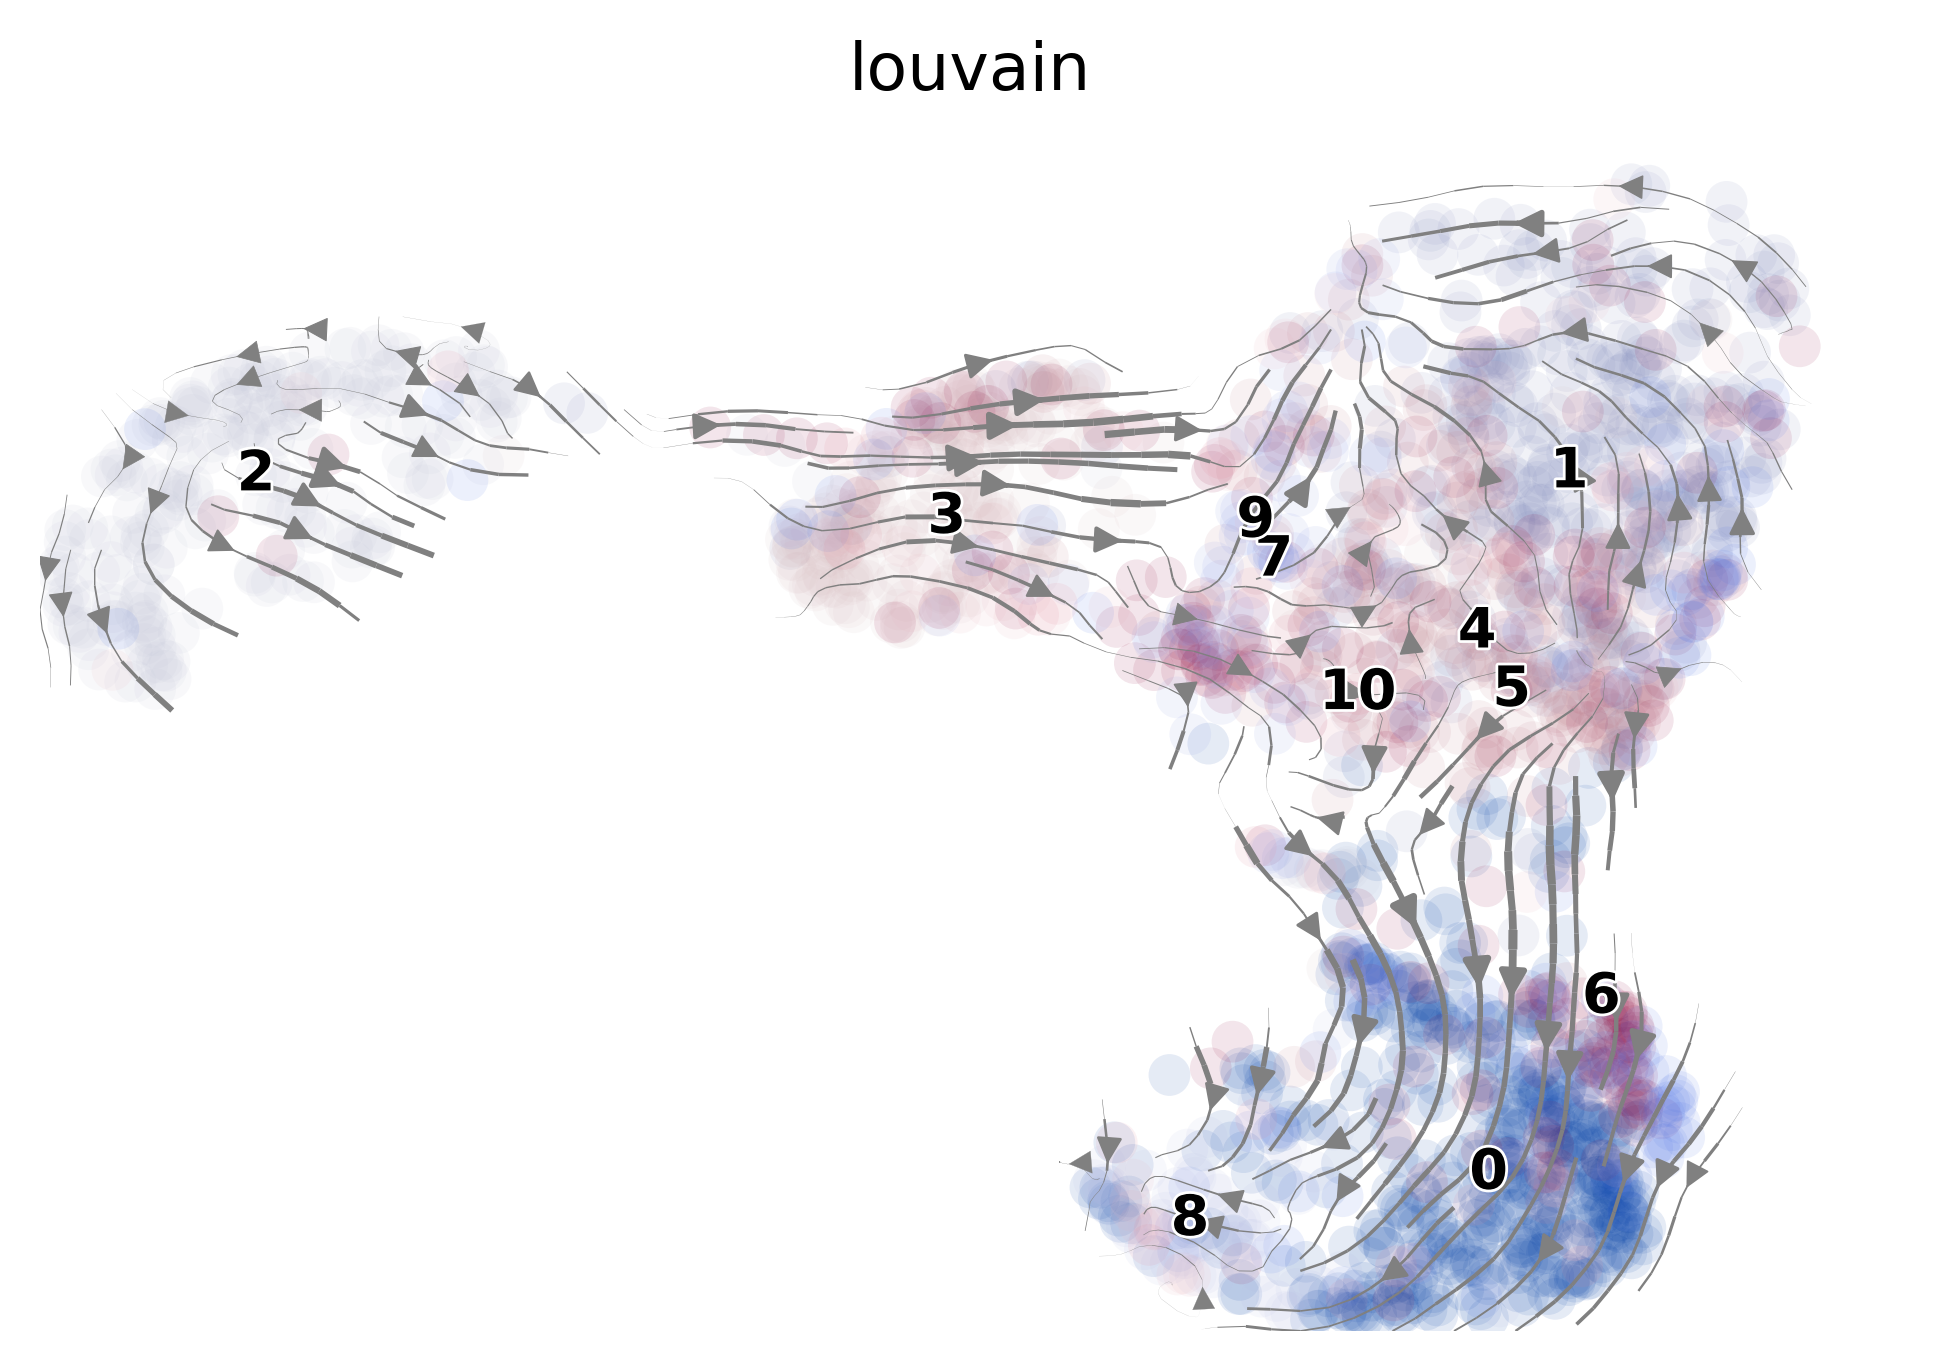

<Figure size 432x288 with 0 Axes>

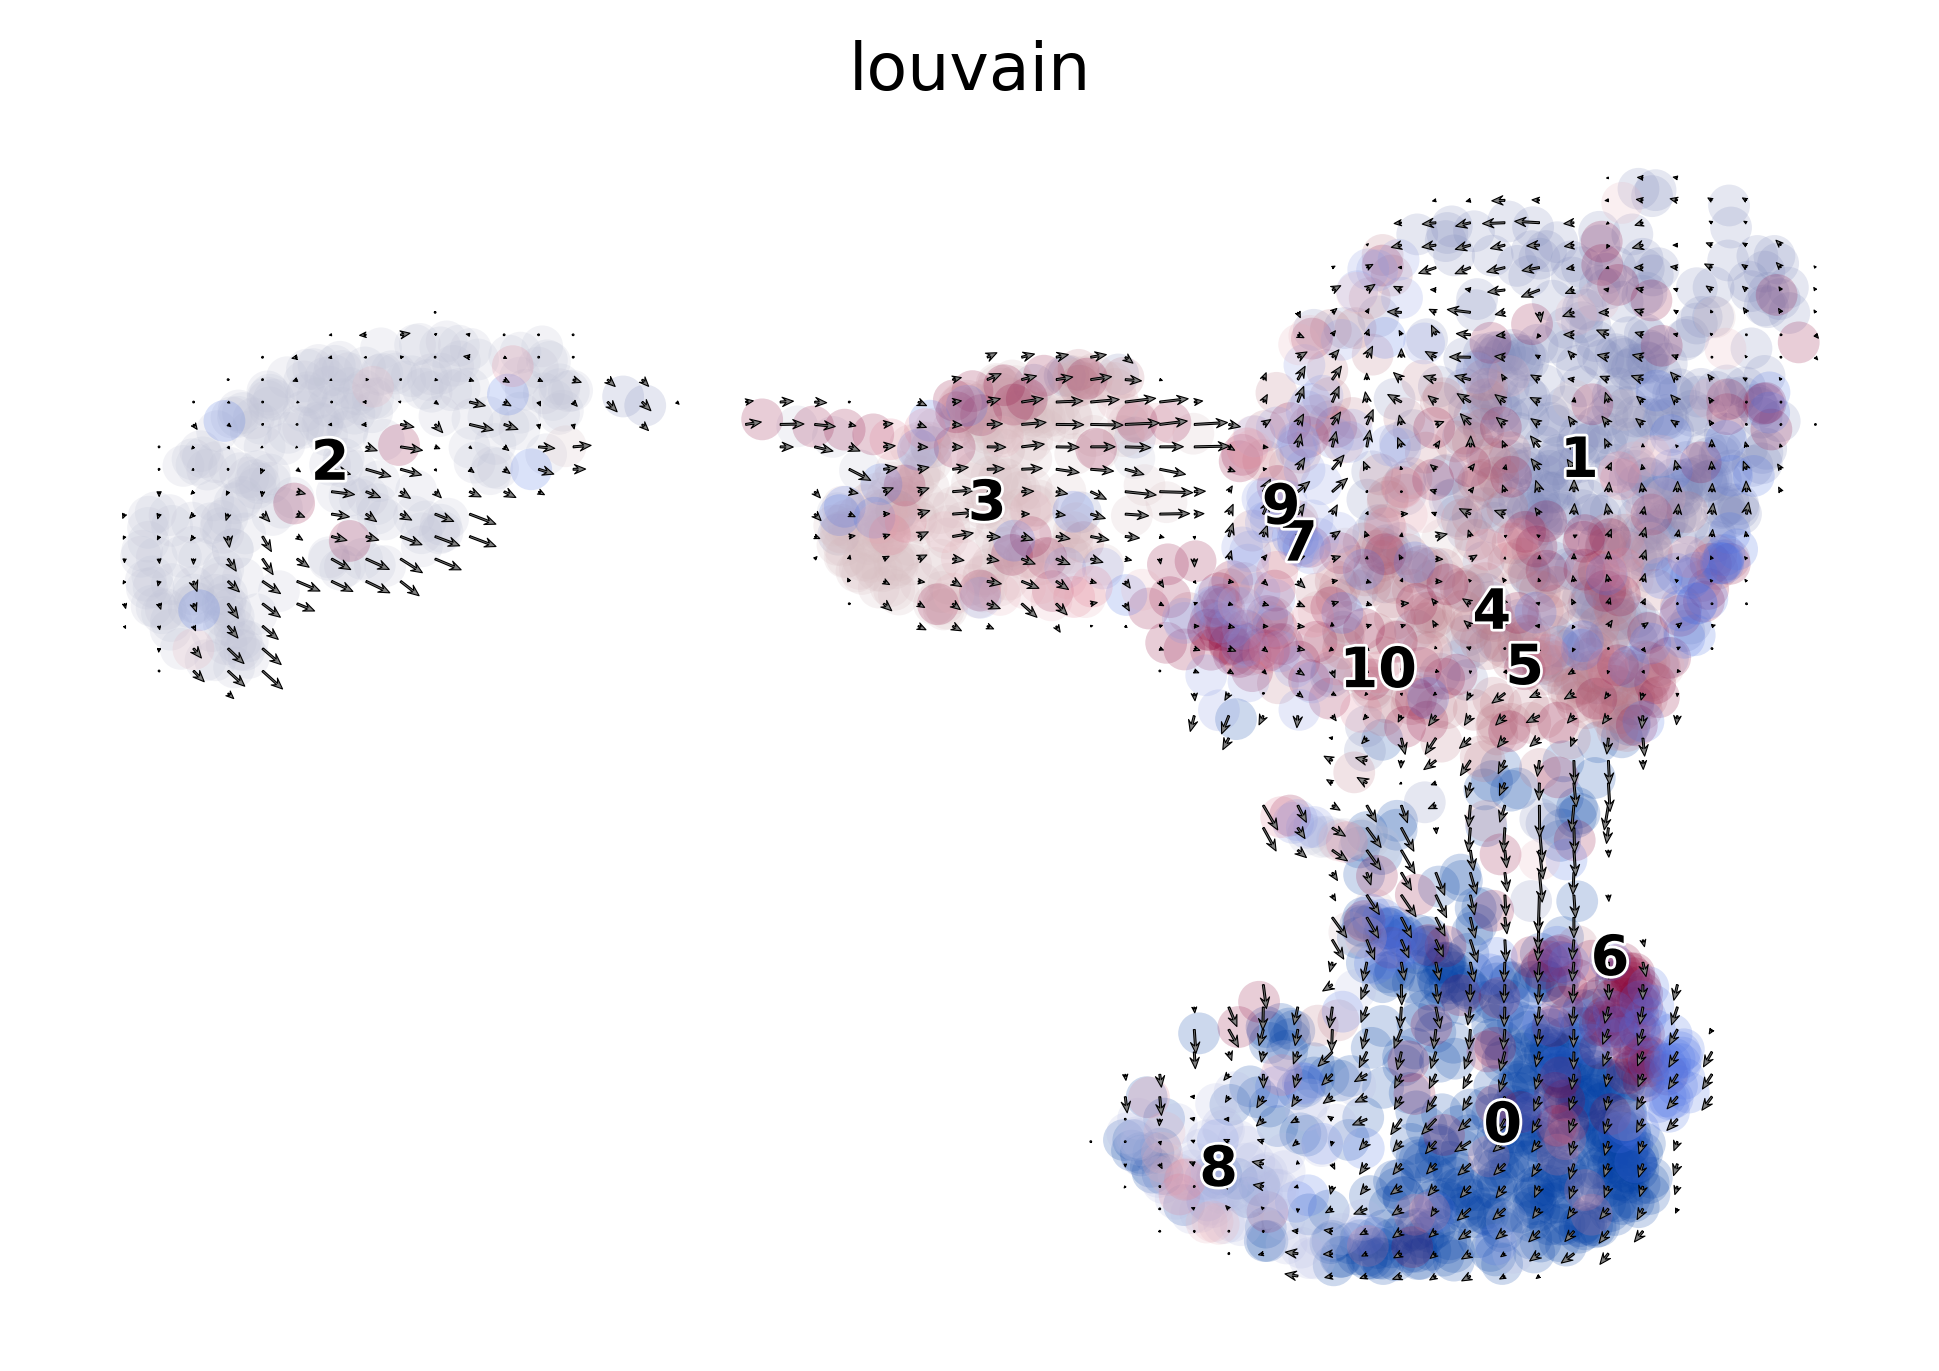

<Figure size 432x288 with 0 Axes>

In [53]:
#/mnt/data/artem/rdata/Adrenal/adrenal_medulla5.UMAP.csv

adata_medulla5 = scv_velocity_on_embedding("/mnt/data/artem/rdata/Adrenal/adrenal_medulla5.UMAP.csv", 
                                      adata_raw, None, 'velocity.cc.medulla5.png')


In [ ]:
scv.tl.recover_latent_time(adata_medulla5)

scv.pl.velocity_embedding_grid(adata_medulla5, density=0.5, arrow_size=2, 
                               color='latent_time', basis='umap', dpi=320, color_map='viridis', 
                               size=70, alpha=0.4, arrow_color='black',
                               figsize=(5,5),
                               save='figures/fig2/medulla5.velocity.5x5.png')


Params:
['/mnt/data/artem/rdata/Adrenal/adrenal_env_6tp_medulla2c.UMAP.csv', AnnData object with n_obs × n_vars = 50014 × 33538 
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', None, 'velocity.cc.15pc.dynamical.umapSR.6tp_medulla2c.R39_w95.R39_w95.png']
Loading loom...
Loading embedding...
Sample names in embedding:
Index(['R30_w8.5_AAACGCTGTATTCCGA', 'R30_w8.5_AAGCGTTCATCACCAA',
       'R30_w8.5_AAGTCGTTCCGTACGG', 'R30_w8.5_AAGTGAACATTGCCTC',
       'R30_w8.5_AATGACCCAACATCGT', 'R30_w8.5_AATTTCCTCGTACACA',
       'R30_w8.5_ACCAACATCCCGTGTT', 'R30_w8.5_ACCCTTGTCAGGAGAC',
       'R30_w8.5_ACCTACCCATATCTCT'],
      dtype='object')
Sample names in loom:
Index(['R30_w8.5_AAACGCTAGTAGTCCT', 'R30_w8.5_AAAGGTACAAAGGCTG',
       'R30_w8.5_AAATGGAAGCTGCCTG', 'R30_w8.5_AAAGTCCGTCGTCGGT',
       'R30_w8.5_AAACGCTGTATTCCGA', 'R30_w8.5_AAAGTCCCACGGTAGA',
       'R30_w8.5_AAAGTCCCATTGCAAC', 'R30_w8.5_AAAGGGCGTTT

Trying to set attribute `.obs` of view, making a copy.


after cell filtering:
(1631, 33538)
after removal of cell cycle genes:
(1631, 33538)
Velocity...
Filtered out 26160 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
recovering dynamics
    finished (0:02:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Clustering...
Plot...
velocity.cc.15pc.dynamical.umapSR.6tp_medul

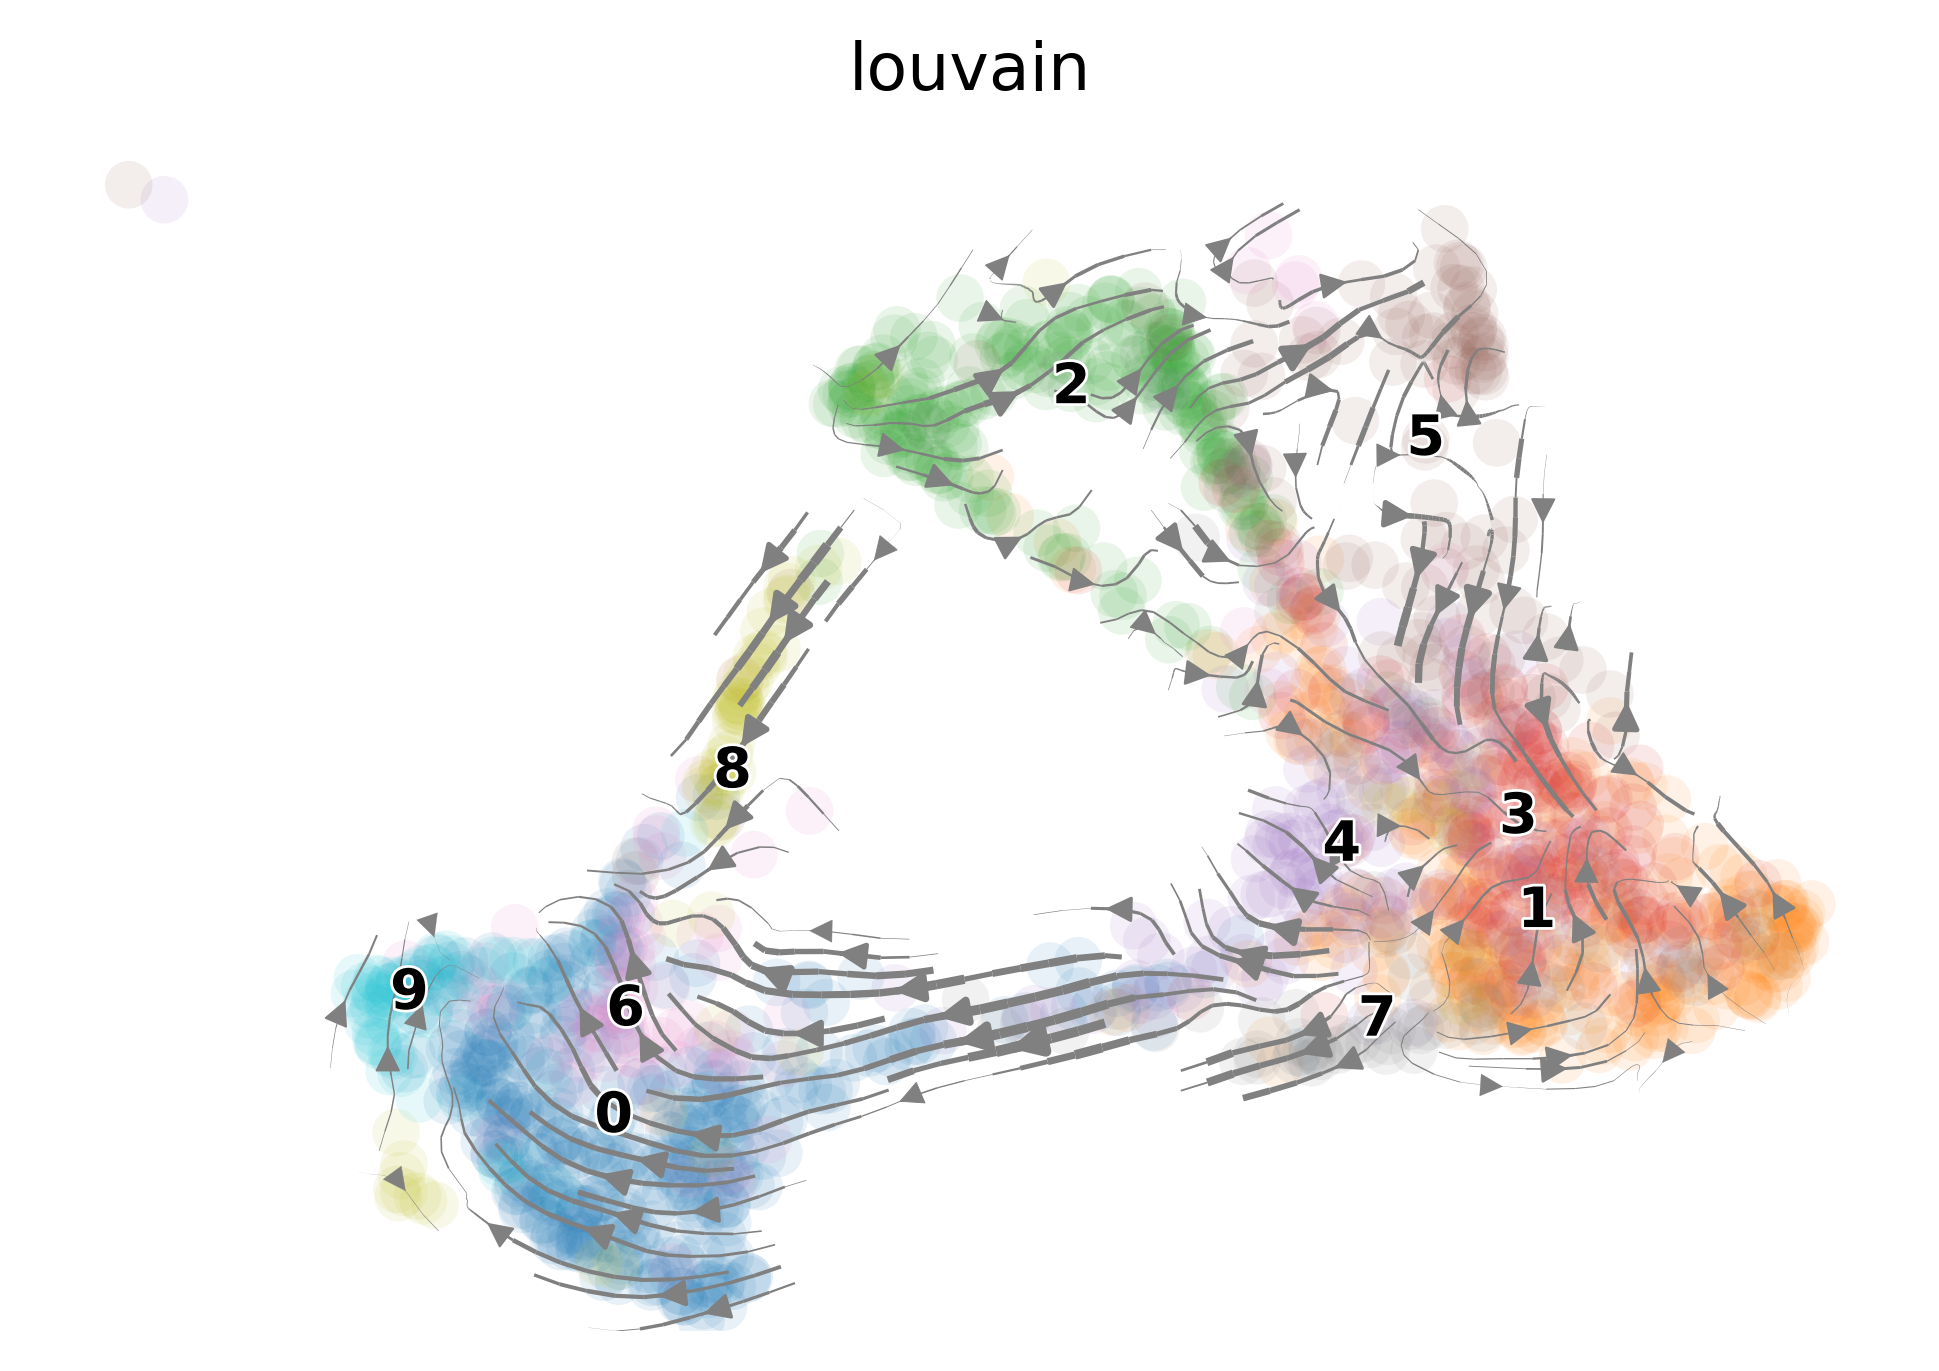

<Figure size 432x288 with 0 Axes>

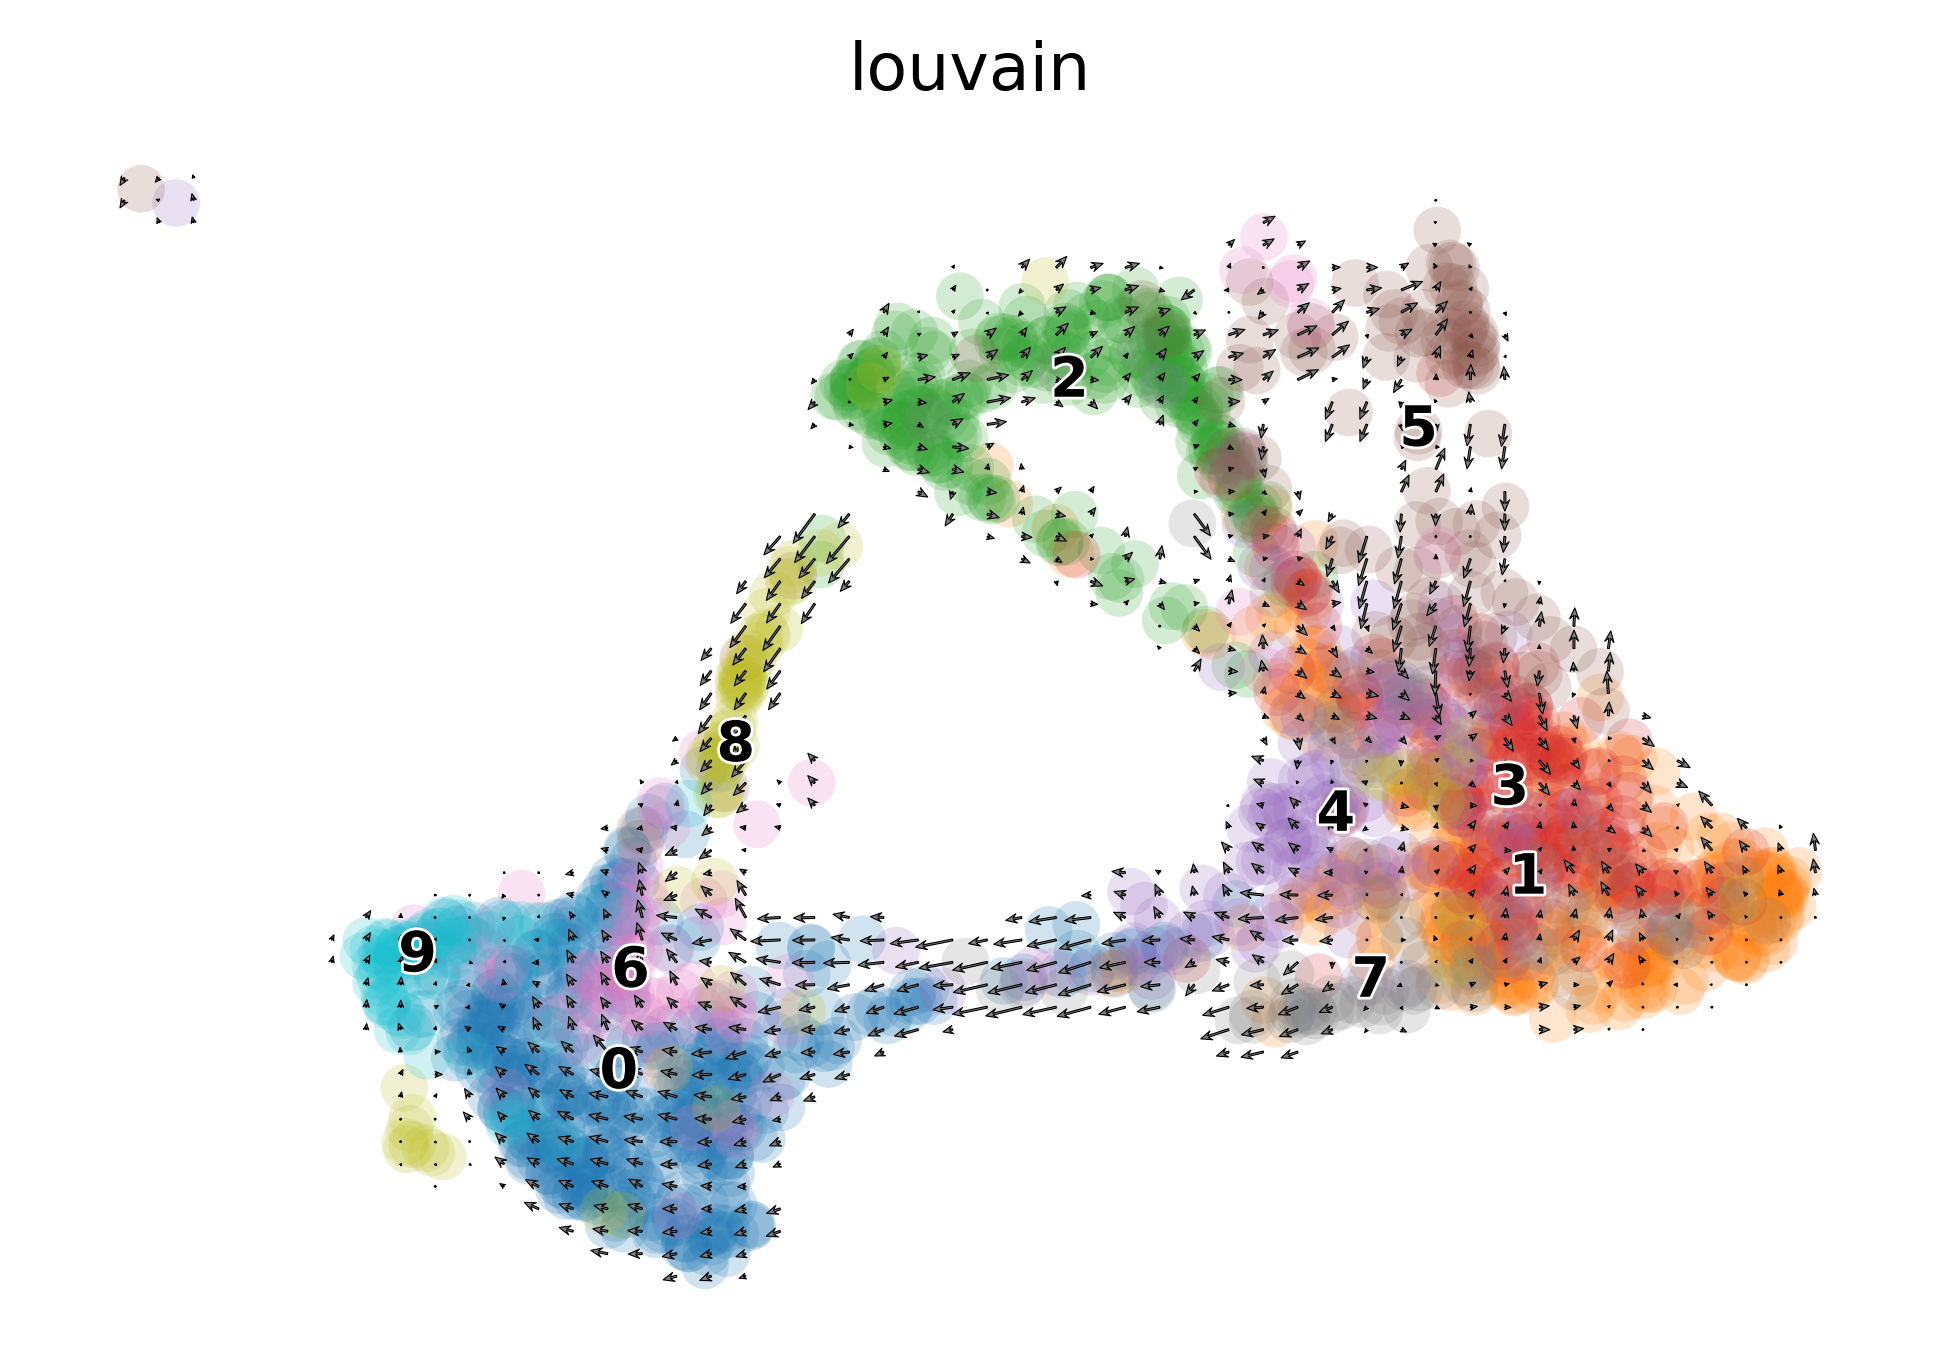

AnnData object with n_obs × n_vars = 1631 × 2000 
    obs: 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'louvain'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg', 'louvain', 'louvain_colors'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'

<Figure size 432x288 with 0 Axes>

In [13]:
scv_velocity_on_embedding("/mnt/data/artem/rdata/Adrenal/adrenal_env_6tp_medulla2c.UMAP.csv", 
                                      adata_raw, None, 'velocity.cc.15pc.dynamical.umapSR.6tp_medulla2c.R39_w95.R39_w95.png')


Params:
['/mnt/data/artem/rdata/Adrenal/adrenal_env_6tp_medulla2c.UMAP.csv', AnnData object with n_obs × n_vars = 50014 × 33538 
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', None, 'velocity.cc.15pc.dynamical.umapSR.6tp_medulla2c.R39_w95.R39_w95.png']
Loading loom...
Loading embedding...
Sample names in embedding:
Index(['R30_w8.5_AAACGCTGTATTCCGA', 'R30_w8.5_AAGCGTTCATCACCAA',
       'R30_w8.5_AAGTCGTTCCGTACGG', 'R30_w8.5_AAGTGAACATTGCCTC',
       'R30_w8.5_AATGACCCAACATCGT', 'R30_w8.5_AATTTCCTCGTACACA',
       'R30_w8.5_ACCAACATCCCGTGTT', 'R30_w8.5_ACCCTTGTCAGGAGAC',
       'R30_w8.5_ACCTACCCATATCTCT'],
      dtype='object')
Sample names in loom:
Index(['R30_w8.5_AAACGCTAGTAGTCCT', 'R30_w8.5_AAAGGTACAAAGGCTG',
       'R30_w8.5_AAATGGAAGCTGCCTG', 'R30_w8.5_AAAGTCCGTCGTCGGT',
       'R30_w8.5_AAACGCTGTATTCCGA', 'R30_w8.5_AAAGTCCCACGGTAGA',
       'R30_w8.5_AAAGTCCCATTGCAAC', 'R30_w8.5_AAAGGGCGTTT

Trying to set attribute `.obs` of view, making a copy.


after cell filtering:
(1631, 33538)
after removal of cell cycle genes:
(1631, 33538)
Velocity...
Filtered out 26160 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
recovering dynamics
    finished (0:02:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Clustering...
Plot...
velocity.cc.15pc.dynamical.umapSR.6tp_medul

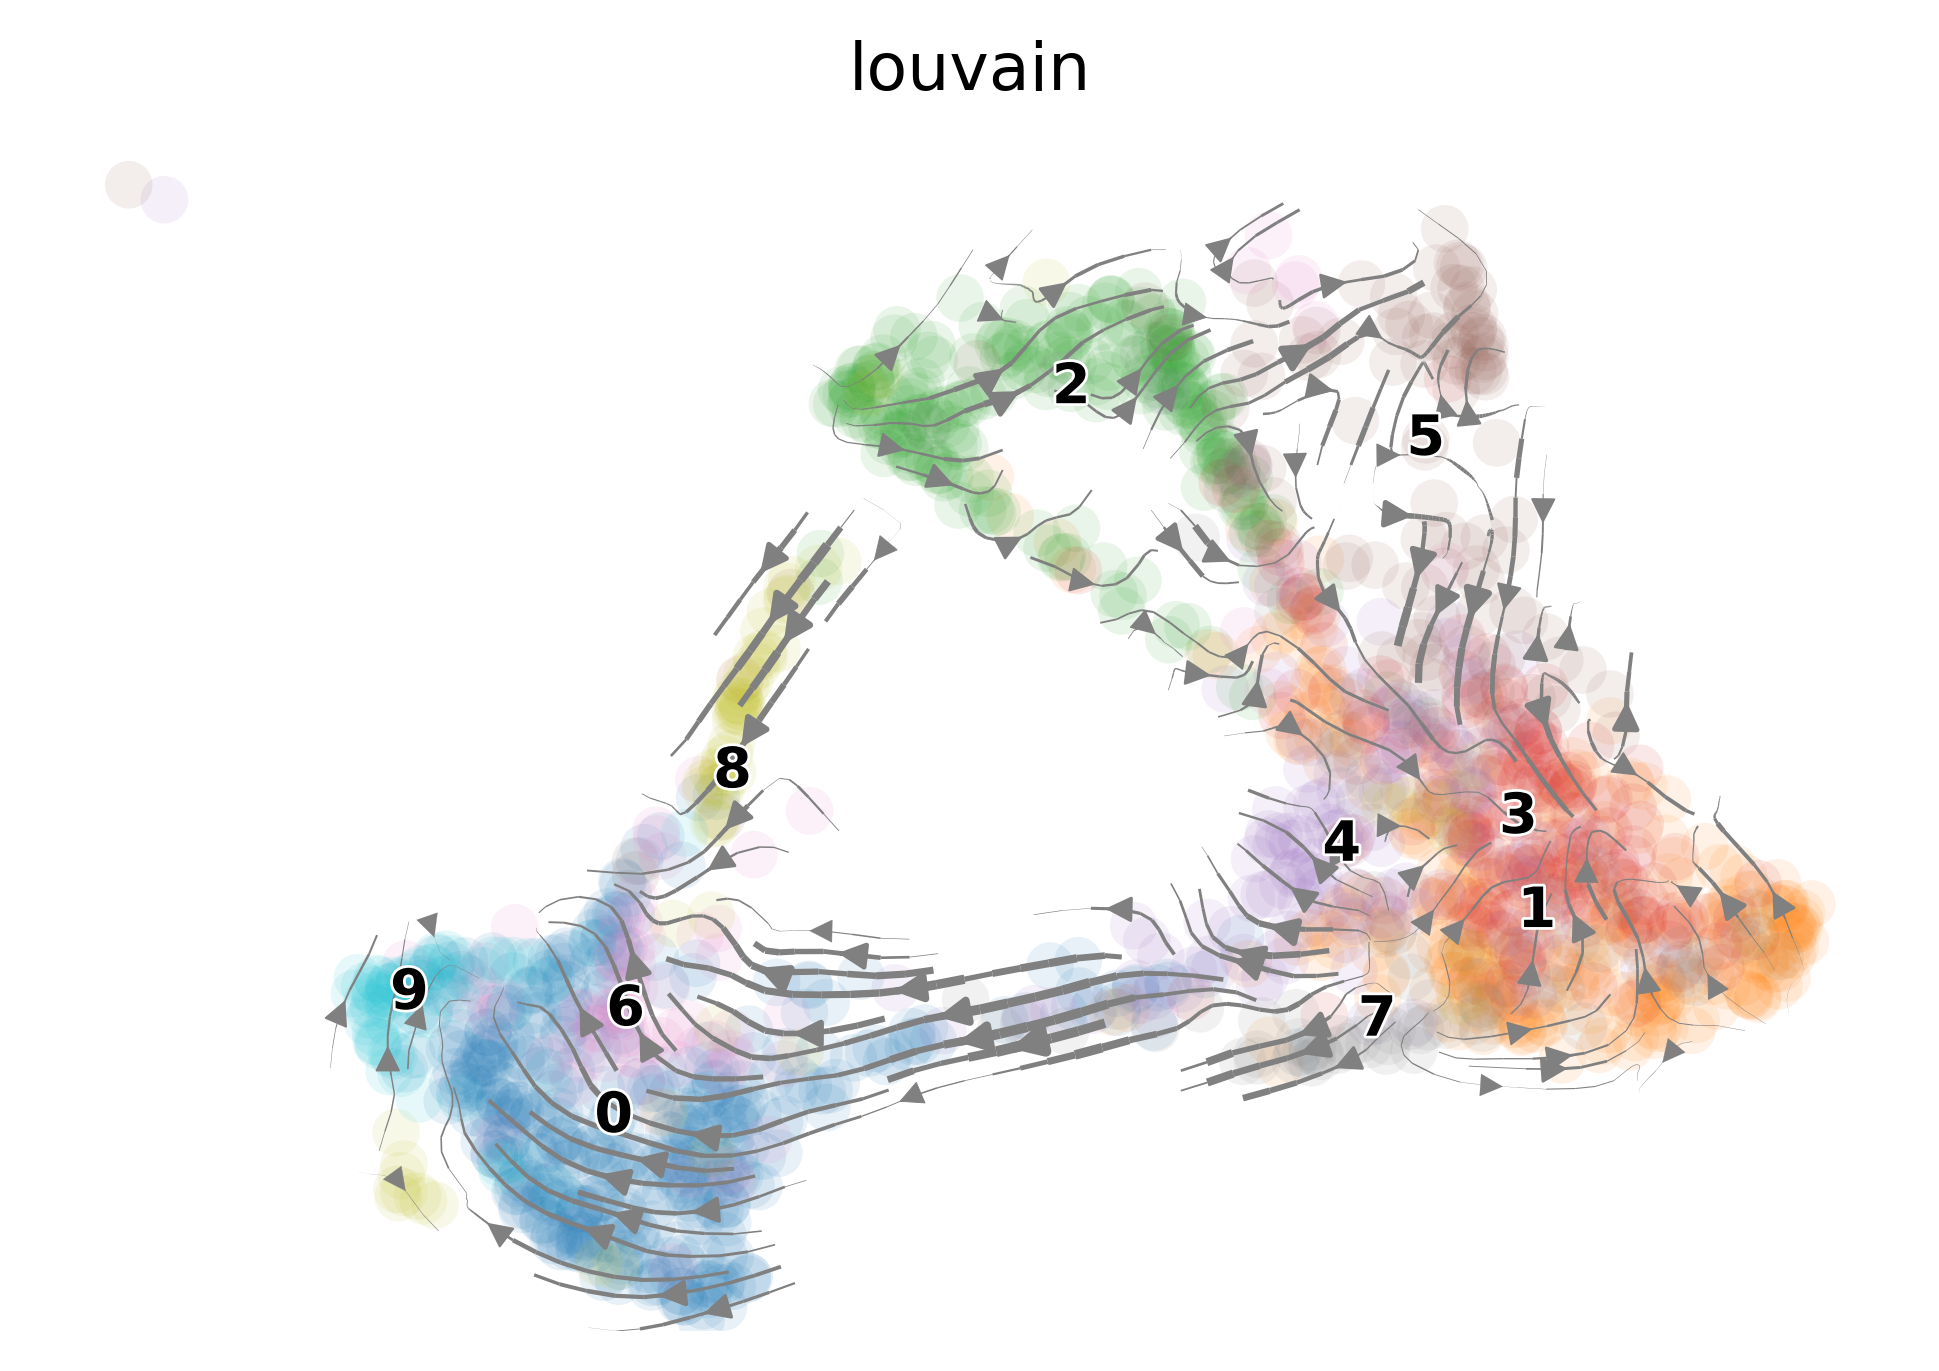

<Figure size 432x288 with 0 Axes>

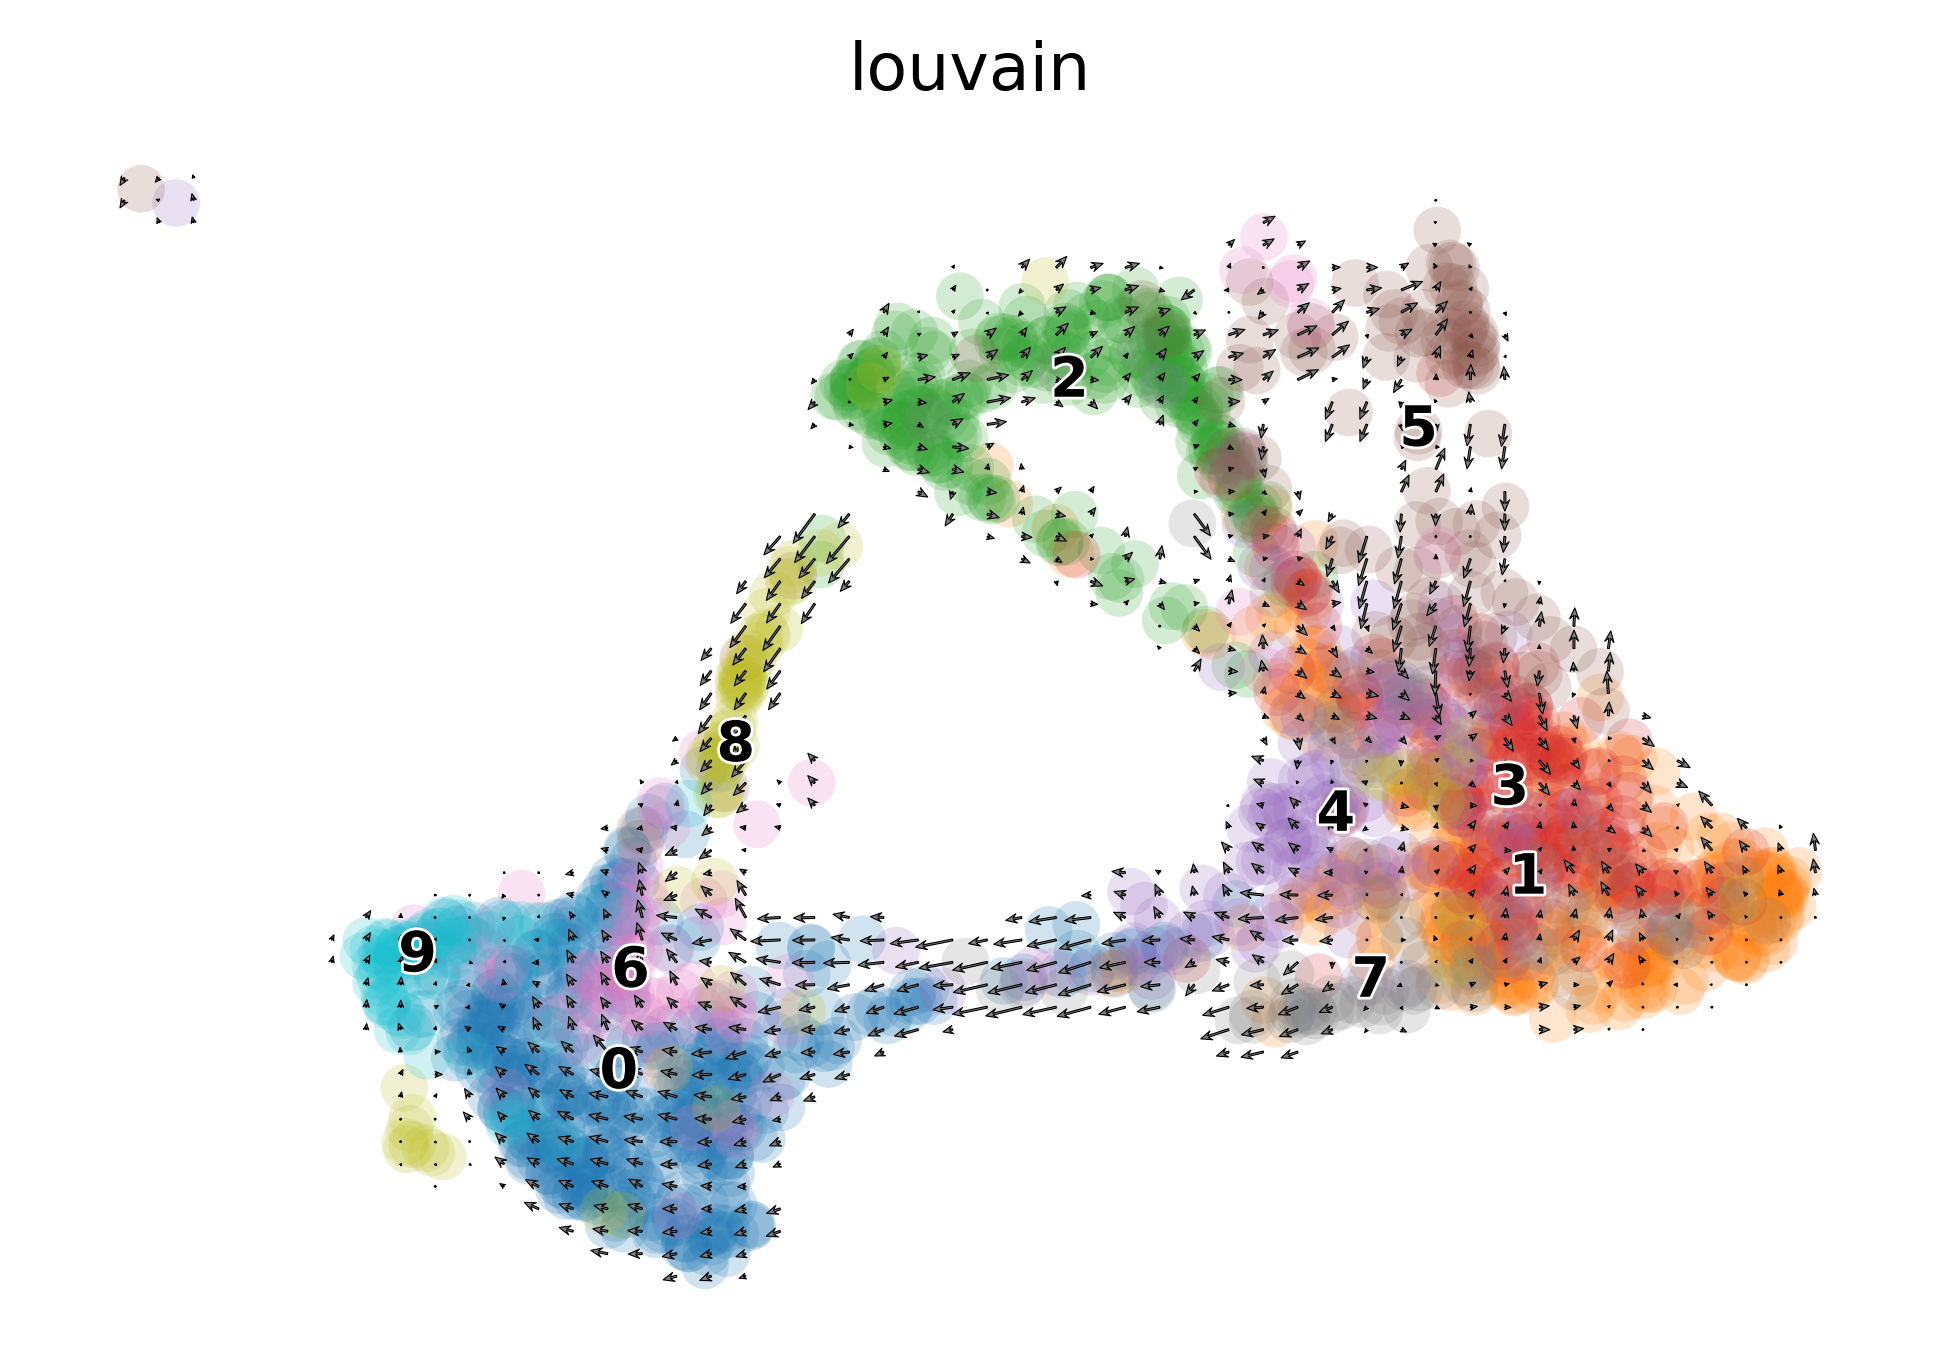

<Figure size 432x288 with 0 Axes>

In [15]:
adata_medulla_small = scv_velocity_on_embedding("/mnt/data/artem/rdata/Adrenal/adrenal_env_6tp_medulla2c.UMAP.csv", 
                                      adata_raw, None, 'velocity.cc.15pc.dynamical.umapSR.6tp_medulla2c.R39_w95.R39_w95.png')


In [17]:
sc.tl.louvain(adata_medulla_small)

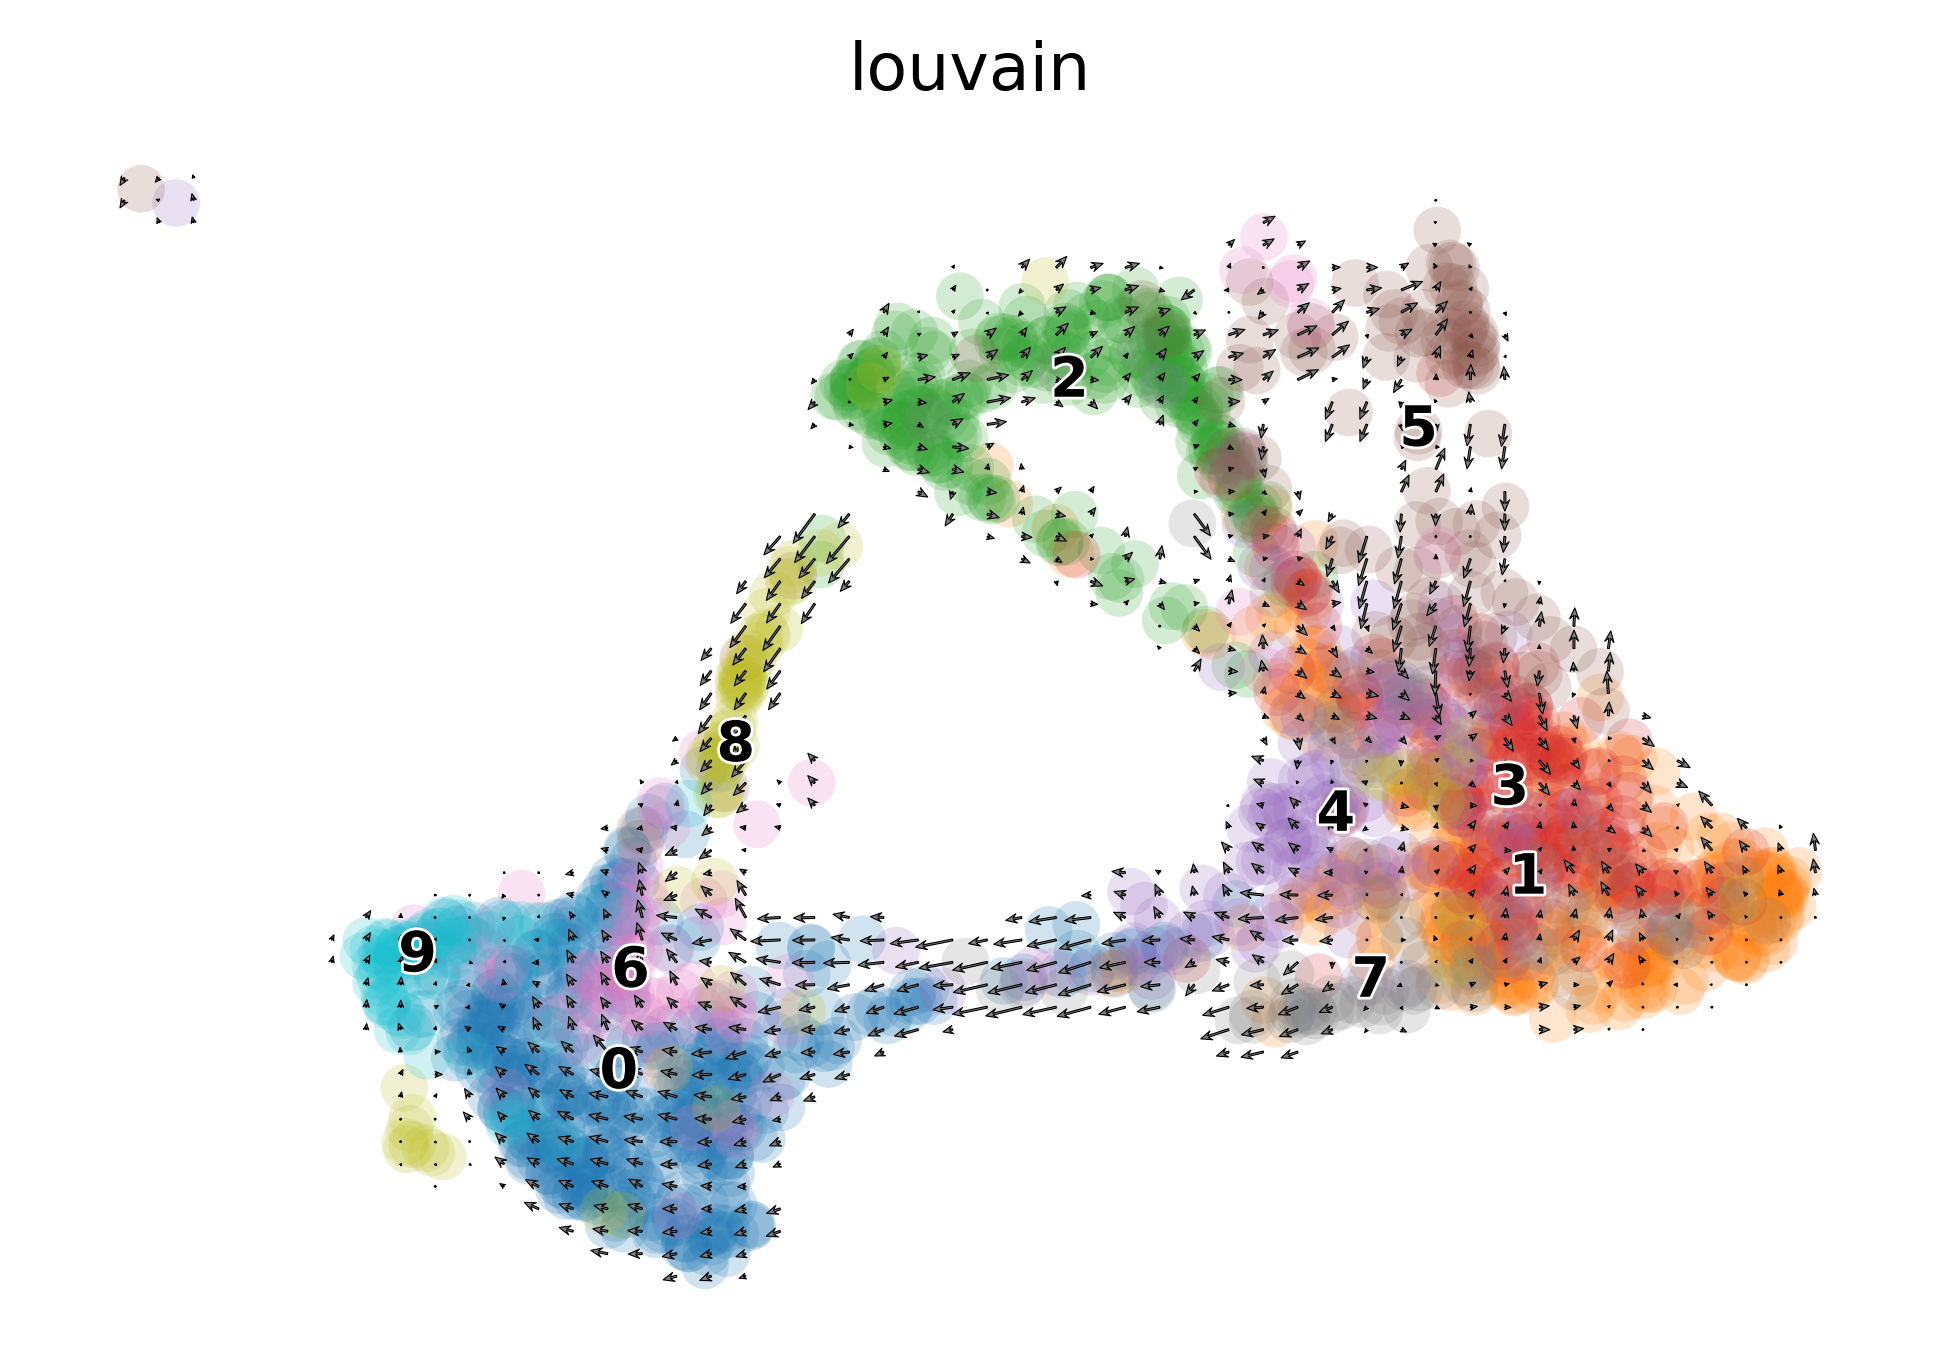

In [19]:
scv.pl.velocity_embedding_grid(adata_medulla_small, legend_loc='on data', basis='umap', dpi=400)#, save=fout_figure)

computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


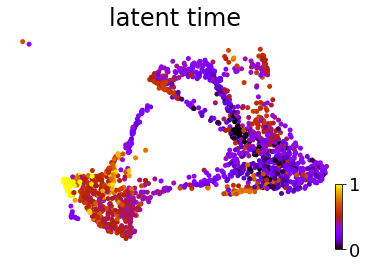

In [20]:
adata = adata_medulla_small

scv.tl.recover_latent_time(adata)

scv.pl.scatter(adata, color='latent_time', fontsize=24, size=100,
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1])


saving figure to file ./figures/scvelo_figures/fig2/medulla2c.velocity.5x5.png


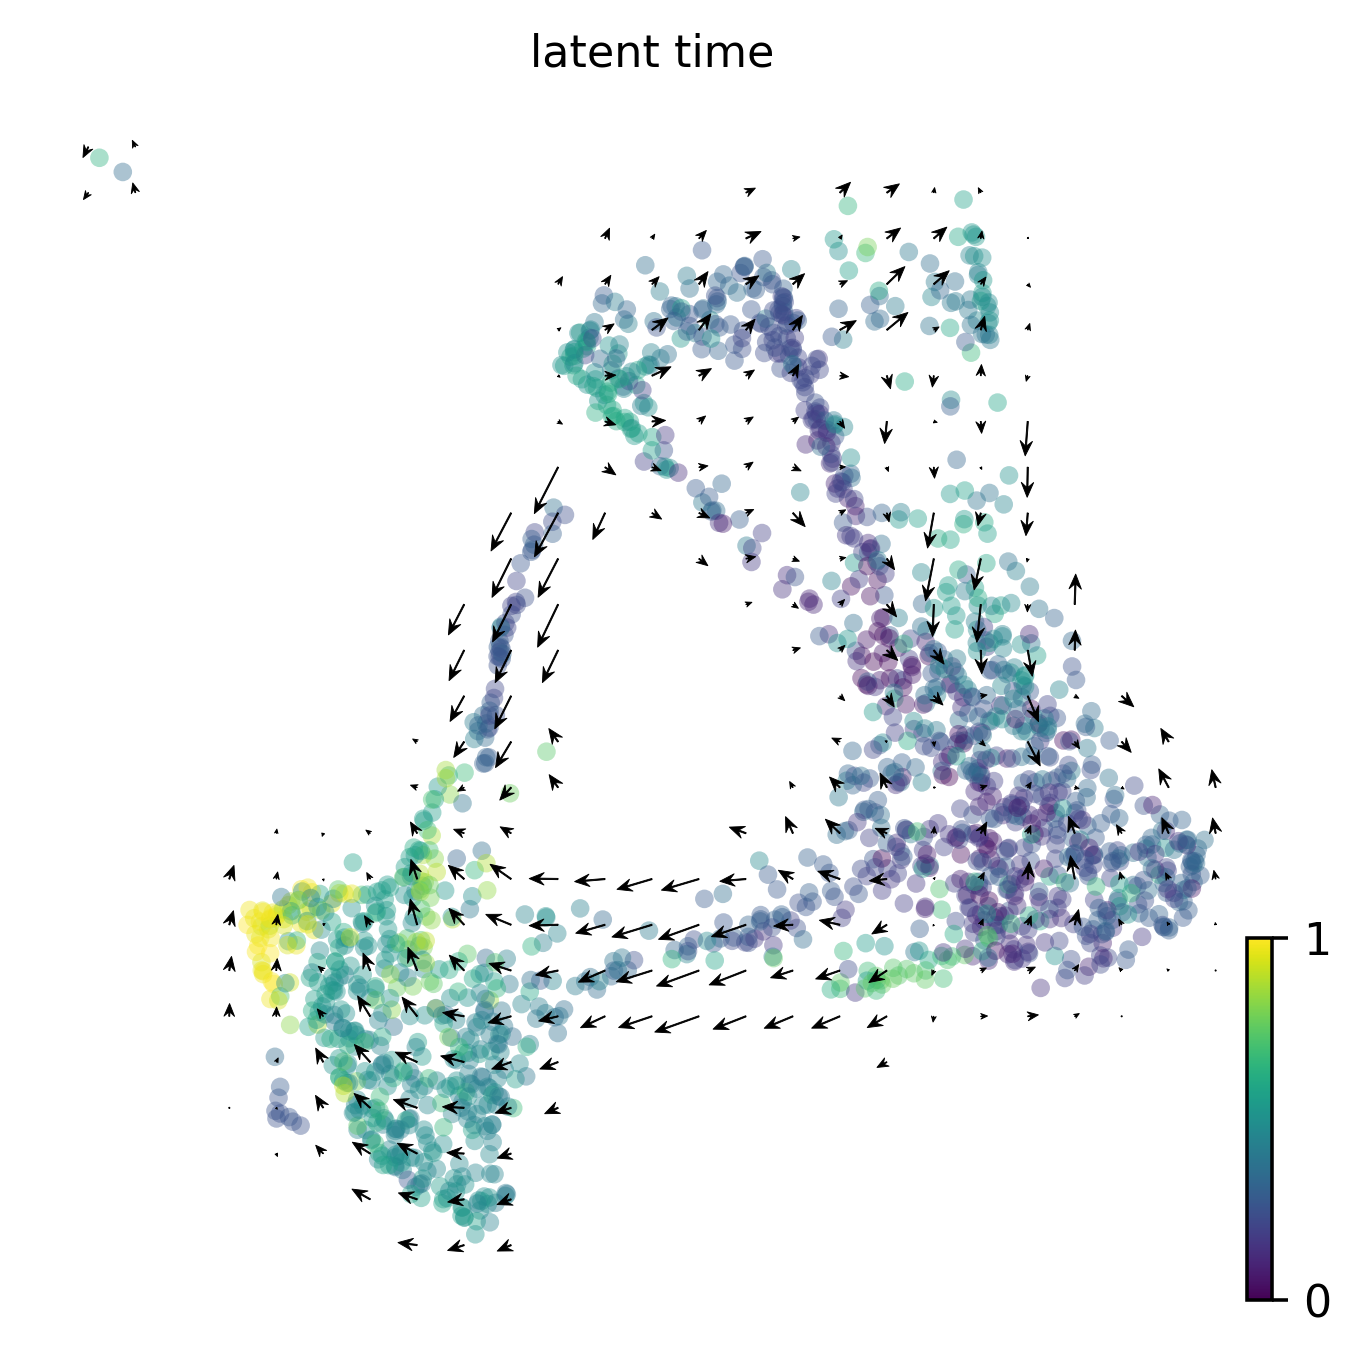

In [51]:
scv.pl.velocity_embedding_grid(adata_medulla_small, density=0.5, arrow_size=2, 
                               color='latent_time', basis='umap', dpi=320, color_map='viridis', 
                               size=70, alpha=0.4, arrow_color='black',
                               figsize=(5,5),
                               save='figures/fig2/medulla2c.velocity.5x5.png')
                              #principal_curve=True)#, save=fout_figure)